# 6. Decision Trees and Ensemble Learning

## 6.1 Credit scoring project 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn')

## 6.2 Data Cleaning

In [2]:
df = pd.read_csv("CreditScoring.csv")
df.head(10)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
5,1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
6,1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
7,1,9,5,12,27,1,1,1,35,80,0,0,200,1093
8,1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957
9,2,0,5,48,41,2,1,2,90,80,0,0,1200,1468


In [3]:
df.columns = df.columns.str.lower()

To understand what every variable is, we need to decode the values of each of the variables.

In [4]:
mapping = {
    'status' : {
        1: 'ok',
        2: 'default',
        0: 'unk'
        },
    'home' : {
        1: 'rent',
        2: 'owner',
        3: 'private',
        4: 'ignore',
        5: 'parents',
        6: 'other',
        0: 'unk'
        },
    'marital' : {
        1: 'single',
        2: 'married',
        3: 'widow',
        4: 'separated',
        5: 'divorced',
        0: 'unk'
        },
    'records' : {
        1: 'no',
        2: 'yes',
        0: 'unk'
        },
    'job' : {
        1: 'fixed',
        2: 'partime',
        3: 'freelance',
        4: 'others',
        0: 'unk'
    }

}

In [5]:
for k,v in mapping.items():
    df[k] = df[k].map(v)

In [6]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [7]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


Now, we need to replace big numbers (99999999) to NaNs

In [8]:
for c in ['income','assets','debt']:
    df[c] = df[c].replace(to_replace=99999999,value=np.nan)

In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [10]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

### Train/Val/Test split

In [12]:
from sklearn.model_selection import train_test_split 

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=11)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [15]:
del df_train['status']
del df_val['status']
del df_test['status']

In [16]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision Trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree 

Lets create a "decision tree" based on some simple rules:

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [18]:
xi = df_train.iloc[0].to_dict()
xi 

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [19]:
assess_risk(xi)

'ok'

The rules that the decision tree provides are learnt from the data. Let's train a decision tree using sckit-learn

In [20]:
from sklearn.tree import DecisionTreeClassifier,export_text 
from sklearn.feature_extraction import DictVectorizer 
from sklearn.metrics import roc_auc_score 

In [21]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
print(dv.get_feature_names_out())

['age' 'amount' 'assets' 'debt' 'expenses' 'home=ignore' 'home=other'
 'home=owner' 'home=parents' 'home=private' 'home=rent' 'home=unk'
 'income' 'job=fixed' 'job=freelance' 'job=others' 'job=partime' 'job=unk'
 'marital=divorced' 'marital=married' 'marital=separated' 'marital=single'
 'marital=unk' 'marital=widow' 'price' 'records=no' 'records=yes'
 'seniority' 'time']


In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
y_pred_train = dt.predict_proba(X_train)[:,1]
y_pred_val = dt.predict_proba(X_val)[:,1]
print(f"The roc auc score for the training dataset is {round(roc_auc_score(y_train,y_pred_train),3)}")
print(f"The roc auc score for the validation dataset is {round(roc_auc_score(y_val,y_pred_val),3)}")

The roc auc score for the training dataset is 1.0
The roc auc score for the validation dataset is 0.661


As we see above, the roc auc score for the training dataset is 1. This indicates that the model is overfitted due to memorizing all the training data but the model can not generalized. 

This ocurrs in Decision trees for different reasons:
- The model learn very specific rules from the training dataset
- The decision tree is too deep, so it can learn many combinations for rules while memorizing the training data.

Lets train a model that has a depth of 3


In [25]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train) 
y_pred_train = dt.predict_proba(X_train)[:,1]
y_pred_val = dt.predict_proba(X_val)[:,1]
train_auc = round(roc_auc_score(y_train,y_pred_train),3) 
val_auc = round(roc_auc_score(y_val,y_pred_val),3) 

print(f"ROC AUC in training dataset {train_auc}")
print(f"ROC AUC in validation dataset {val_auc}")

ROC AUC in training dataset 0.776
ROC AUC in validation dataset 0.739


A tree with depth one is called decision stump

In [26]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train,y_train) 
y_pred_train = dt.predict_proba(X_train)[:,1]
y_pred_val = dt.predict_proba(X_val)[:,1]
train_auc = round(roc_auc_score(y_train,y_pred_train),3) 
val_auc = round(roc_auc_score(y_val,y_pred_val),3) 

print(f"ROC AUC in training dataset {train_auc}")
print(f"ROC AUC in validation dataset {val_auc}")

ROC AUC in training dataset 0.628
ROC AUC in validation dataset 0.606


We can visualize the rules that were learnt by the model using `sklearn.trees.export_text`

In [27]:
print(export_text(dt,feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- class: 1
|--- records=no >  0.50
|   |--- class: 0



/home/dc/Envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


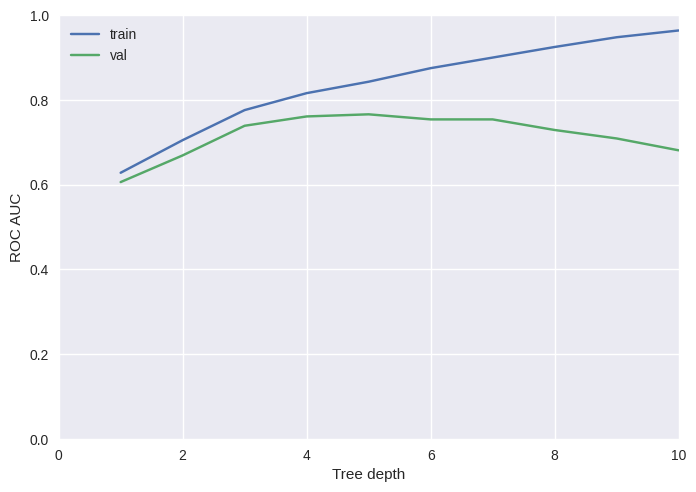

In [28]:
depths = np.arange(1,11,1)
train_aucs = []
val_aucs = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train,y_train) 

    y_pred_train = dt.predict_proba(X_train)[:,1]
    y_pred_val = dt.predict_proba(X_val)[:,1]
    train_auc = round(roc_auc_score(y_train,y_pred_train),3) 
    val_auc = round(roc_auc_score(y_val,y_pred_val),3) 
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

plt.figure()
plt.plot(depths,train_aucs,label='train')
plt.plot(depths,val_aucs,label='val')
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")
plt.legend()

## 6.4 Decision Tree Learning Algorithm 

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

Condition node
```
|--- feature= condition <= threshold
|   |--- False # Decision Node: Leaves
|--- feature= condition >  threshold
|   |--- True # Decision Node: Leaves
```

In [29]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [30]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [31]:
from IPython.display import display

In [32]:
Ts = [2000,3000,4000,5000,8000]

for T in Ts:
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    print(f"Threshold {T}")
    display(df_left)
    display(df_right)
    print('---------')

Threshold 2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


---------
Threshold 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


---------
Threshold 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


---------
Threshold 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


---------
Threshold 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


---------


In [33]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]
display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


To evaluate how the condition threshold affects the classification, we calculate the *misclassification rate* or *impurity, which is the ratio of the uncorrectly classified class for each of the condition leaf

In [34]:
Ts = [0,2000,3000,4000,5000,8000]
df_impurity = pd.DataFrame()
decisions = df_right.status.unique().tolist()
for i,T in enumerate(Ts):

    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    decision_left = df_left.status.mode().values[0]
    impurity_left = round(1 - df_left.status.value_counts(normalize=True)[decision_left],2)
    decision_right = df_right.status.mode().values[0]
    impurity_right = round(1 - df_right.status.value_counts(normalize=True)[decision_right],2)
    
    new_row = {
        'threshold':T,'decision_left':decision_left,'impurity_left':impurity_left,
        'decision_right':decision_right,'impurity_right':impurity_right
    }
    tmp = pd.DataFrame(new_row,index = [i] )
    df_impurity = pd.concat([df_impurity,tmp])
    df_impurity['impurity_avg'] = round((df_impurity['impurity_left'] + df_impurity['impurity_right'])/2,2)

In [35]:
df_impurity

,threshold,decision_left,impurity_left,decision_right,impurity_right,impurity_avg
0,0,default,0.00,ok,0.43,0.22
1,2000,default,0.00,ok,0.33,0.16
2,3000,default,0.00,ok,0.20,0.10
3,4000,default,0.25,ok,0.25,0.25
4,5000,default,0.50,default,0.50,0.50
5,8000,default,0.43,ok,0.00,0.22


So, from the table above we see that the best threshold to condition this feature is $T=3000$. 

What happens now that we want to include an additional feature? 

In [36]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [37]:
df_example.sort_values(by='debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [38]:
thresholds = {
    'assets': [0,2000,3000,4000,5000,8000],
    'debt' : [500,1000,2000]
}

df_impurity = pd.DataFrame()
decisions = df_right.status.unique().tolist()
for feature,Ts in thresholds.items():
    for i,T in enumerate(Ts):

        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        decision_left = df_left.status.mode().values[0]
        impurity_left = round(1 - df_left.status.value_counts(normalize=True)[decision_left],2)
        decision_right = df_right.status.mode().values[0]
        impurity_right = round(1 - df_right.status.value_counts(normalize=True)[decision_right],2)
        
        new_row = {
            'feature':feature,
            'threshold':T,'decision_left':decision_left,'impurity_left':impurity_left,
            'decision_right':decision_right,'impurity_right':impurity_right
        }
        tmp = pd.DataFrame(new_row,index = [i] )
        df_impurity = pd.concat([df_impurity,tmp])
        df_impurity['impurity_avg'] = round((df_impurity['impurity_left'] + df_impurity['impurity_right'])/2,2)

In [39]:
df_impurity

,feature,threshold,decision_left,impurity_left,decision_right,impurity_right,impurity_avg
0,assets,0,default,0.00,ok,0.43,0.22
1,assets,2000,default,0.00,ok,0.33,0.16
2,assets,3000,default,0.00,ok,0.20,0.10
3,assets,4000,default,0.25,ok,0.25,0.25
4,assets,5000,default,0.50,default,0.50,0.50
5,assets,8000,default,0.43,ok,0.00,0.22
0,debt,500,ok,0.00,default,0.43,0.22
1,debt,1000,ok,0.33,default,0.00,0.16
2,debt,2000,ok,0.43,default,0.00,0.22


```
while Stopping_criteria:
    for f in features:
        do find all threshods T for F
        
        for T in thresholds:
            do Split dataset using "Feature > T" condition 
            do Compute Impurity of the leaf
        
    Select best split (Lowest impurity)
    
    Check stop_criteria

    Repeat iteratively for left and right datasets
    

```

Stopping_criteria:
- Group is already pure 
- Max_depth parameter: Stop once the depth limit is reached
- The group size is too small

## 6.5 Decision trees parameter tuning

- Selecting `max_depth`
- Selecting `min_samples_leaf` --> Min group size

In [40]:
aucs = []
for d in [1,2,3,4,5,6,7,8,9,10,15,None]:
    dt =  DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train,y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    aucs.append(auc)
    
    print(f"{d} -> {round(auc,3)}")

1 -> 0.606
2 -> 0.669
3 -> 0.739
4 -> 0.761
5 -> 0.767
6 -> 0.761
7 -> 0.755
8 -> 0.742
9 -> 0.698
10 -> 0.685
15 -> 0.664
None -> 0.657


The optimal `max_depth` is around 4 and 6. If this was the only parameter, we would choose 4 because it provides a simpler model.

Now, lets look at another parameter

In [41]:
aucs = []
scores = []
for d in [4,5,6]:
    for s in [1,2,5,10,15,20,100,200,500]: # min_sample_leaf
        dt =  DecisionTreeClassifier(max_depth=d,min_samples_leaf=s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        #aucs.append(auc)
        
        scores.append({'max_depth':d,'min_samples_leaf':s,'auc':auc})
scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='auc',ascending=False).head(5)

,max_depth,min_samples_leaf,auc
22,6,15,0.785474
21,6,10,0.778299
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773982


In [42]:
scores_pivot = scores_df.pivot(index='min_samples_leaf',columns='max_depth',values=['auc']).round(3)

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

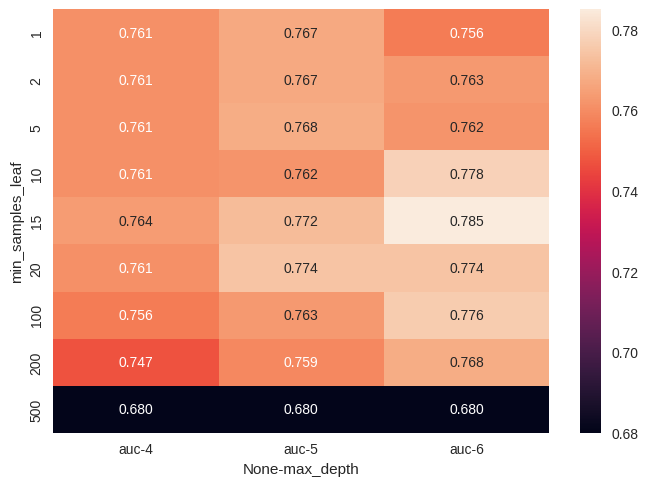

In [43]:
import seaborn as sns 

sns.heatmap(scores_pivot,annot=True,fmt='.3f')

In [44]:
scores = []
for d in [4,5,6,10,15,20,None]:
    for s in [1,2,5,10,15,20,100,200,500]: # min_sample_leaf
        dt =  DecisionTreeClassifier(max_depth=d,min_samples_leaf=s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        #aucs.append(auc)
        
        scores.append({'max_depth':d,'min_samples_leaf':s,'auc':auc})
scores_df = pd.DataFrame(scores)
scores_df.sort_values(by='auc',ascending=False).head(5)

,max_depth,min_samples_leaf,auc
31,10.0,15,0.789494
58,NaN,15,0.788634
49,20.0,15,0.788316
40,15.0,15,0.787517
32,10.0,20,0.786001


<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

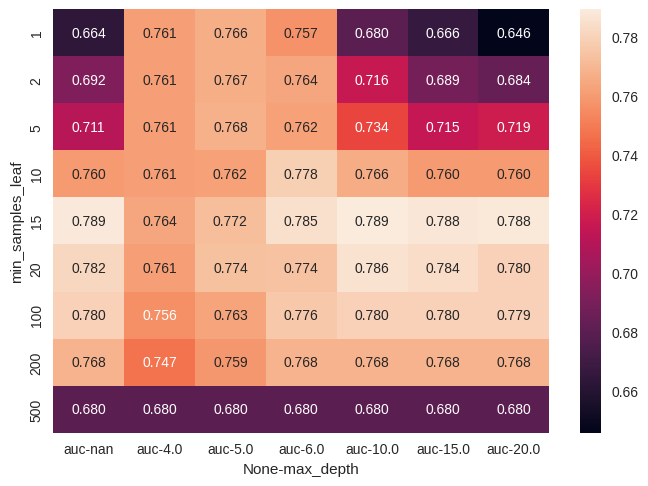

In [45]:
scores_pivot = scores_df.pivot(index='min_samples_leaf',columns='max_depth',values=['auc'])
sns.heatmap(scores_pivot,annot=True,fmt='.3f')

In [46]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=15)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## 6.6 Ensembles and Random Forests

- Board of experts
- Ensembling models
- Random forest - ensembling decision trees 
- Tuning random forests

In [47]:
from sklearn.ensemble import RandomForestClassifier

For reproducibility, it is especially important to fix the `random_state` of the `RandomForestClassifier`

In [48]:
rf = RandomForestClassifier(n_estimators=10,random_state=1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [49]:
y_pred = rf.predict_proba(X_val)[:,1]

roc_auc_score(y_val,y_pred)

0.7744726453706618

<AxesSubplot:xlabel='n_est', ylabel='auc'>

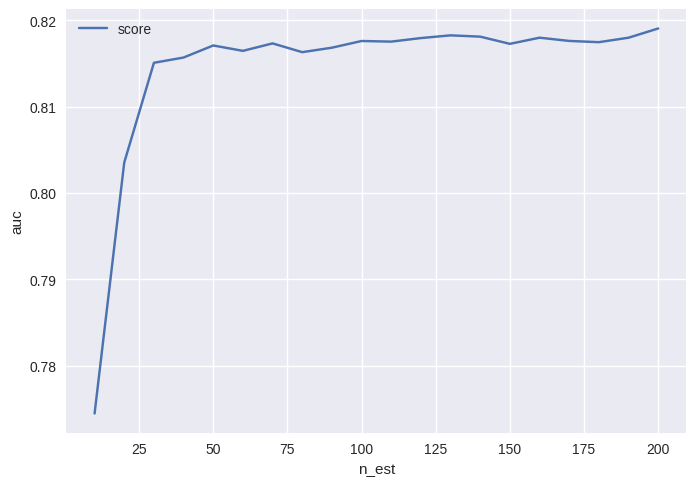

In [50]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n,random_state=1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val,y_pred) 
    scores.append({'n_est':n,'score':auc})

df_scores = pd.DataFrame(scores)

df_scores.plot(x='n_est',y='score',ylabel='auc')

Lets dig into the effect of `max_depth`

In [51]:
scores = []

for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=d,random_state=1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val,y_pred) 
        scores.append({'max_depth':d,'n_est':n,'score':auc})

df_scores = pd.DataFrame(scores)


<AxesSubplot:xlabel='n_est', ylabel='score'>

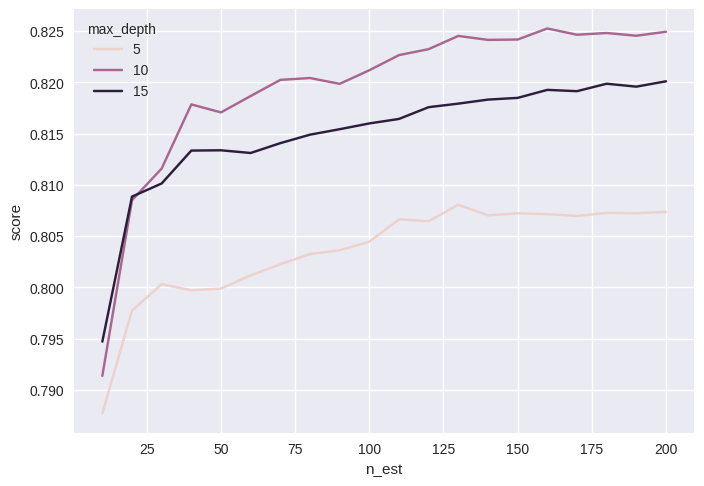

In [52]:
sns.lineplot(x='n_est',y='score',hue='max_depth',data=df_scores)


What about changing the `min_samples_leaf`?
Lets keep `max_depth` as 10, given the step above.

In [53]:
scores = []

for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=10,min_samples_leaf=s,random_state=1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val,y_pred) 
        scores.append({'min_samples_leaf':s,'n_est':n,'score':auc})

df_scores = pd.DataFrame(scores)

<AxesSubplot:xlabel='n_est', ylabel='score'>

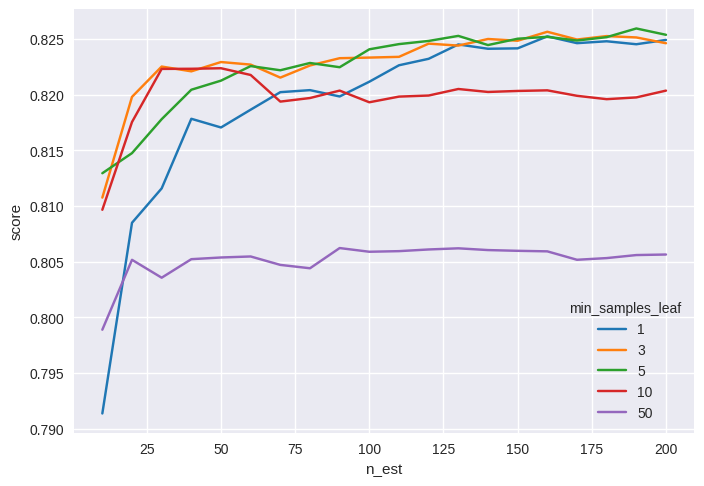

In [54]:
sns.lineplot(x='n_est',y='score',hue='min_samples_leaf',palette='tab10',data=df_scores)

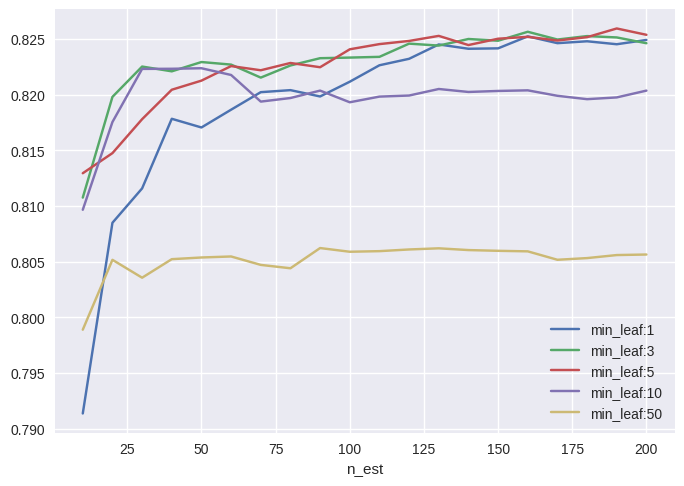

In [55]:
fig,ax = plt.subplots()

for s in [1,3,5,10,50]:
    sub = df_scores[df_scores.min_samples_leaf == s]
    sub.plot(x='n_est',y='score',label=f'min_leaf:{s}',ax=ax)

In [56]:
params = {
    'n_estimators':200,
    'max_depth':10,
    'min_samples_leaf' : 3,
}

rf = RandomForestClassifier(**params,random_state=1)
rf.fit(X_train,y_train) 

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [57]:
y_pred = rf.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val,y_pred)

## 6.7 Gradient boosting and XGBoost 

- Gradient boosting vs Random Forest
- XGBoost
- Training first model 
- Performance monitoring 
- Parsing xgboots monitoring output



In [58]:
import xgboost as xgb

In [60]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=features)
dval = xgb.DMatrix(X_val,label=y_val,feature_names=features)

/home/dc/Envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
xgb_params = {
    "eta":0.3, #Learning rate
    "max_depth":6,
    "min_child_weight": 1,

    "objective":"binary:logistic",
    'nthread':8,

    'seed': 1,
    'verbosity':1,
}

model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=10)

In [71]:
y_pred = model.predict(dval)

In [72]:
roc_auc_score(y_val,y_pred)

0.8152745150274878

<AxesSubplot:>

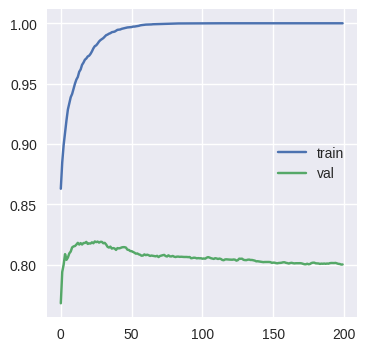

In [92]:
watch_list = [(dtrain,'train'),(dval,'val')]

xgb_params = {
    "eta":0.3, #Learning rate
    "max_depth":6,
    "min_child_weight": 1,

    "objective":"binary:logistic",
    "eval_metric" : 'auc',
    'nthread':8,

    'seed': 1,
    'verbosity':0,
}

evals_result = {}
model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=200,
                evals_result=evals_result,verbose_eval=False,evals=watch_list)
df_scores = pd.DataFrame([evals_result['train']['auc'],evals_result['val']['auc']]).T
df_scores.columns = ['train','val']
df_scores.plot(figsize=(4,4))

## 6.7 XGBoost Parameter Tuning 

- Eta [Learning rate]: Step size used to modify the weights of the previous model

In [104]:

etas = [1.0,0.3,0.1,0.05]
scores = pd.DataFrame()
for eta in etas:
    xgb_params = {
        "eta":eta, #Learning rate
        "max_depth":6,
        "min_child_weight": 1,

        "objective":"binary:logistic",
        "eval_metric" : 'auc',
        'nthread':8,

        'seed': 1,
        'verbosity':0,
    }

    evals_result = {}
    model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=200,
                    evals_result=evals_result,verbose_eval=False,evals=watch_list)
    df_scores = pd.DataFrame([evals_result['train']['auc'],evals_result['val']['auc']]).T
    df_scores.columns = ['train','val']
    df_scores['eta'] = eta 
    scores = pd.concat([scores,df_scores])


<AxesSubplot:ylabel='val'>

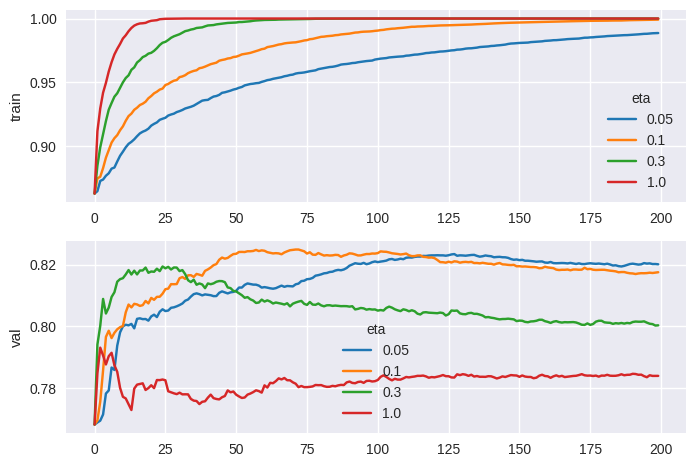

In [105]:
fig,ax=plt.subplots(nrows=2)
sns.lineplot(x=scores.index,y=scores.train,hue=scores.eta,palette='tab10',ax=ax[0])
sns.lineplot(x=scores.index,y=scores.val,hue=scores.eta,palette='tab10',ax=ax[1])

Lets select `eta` as 0.1, which provides the better tradeoff performance between validation auc and number of models.

Now, lets look a `max_depth` 

In [114]:
depths = [3,4,6]
scores = pd.DataFrame()
for d in depths:
    xgb_params = {
        "eta":0.1, #Learning rate
        "max_depth":d,
        "min_child_weight": 1,

        "objective":"binary:logistic",
        "eval_metric" : 'auc',
        'nthread':8,

        'seed': 1,
        'verbosity':0,
    }

    evals_result = {}
    model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=200,
                    evals_result=evals_result,verbose_eval=False,evals=watch_list)
    df_scores = pd.DataFrame([evals_result['train']['auc'],evals_result['val']['auc']]).T
    df_scores.columns = ['train','val']
    df_scores['max_depth'] = d
    scores = pd.concat([scores,df_scores])

<AxesSubplot:ylabel='val'>

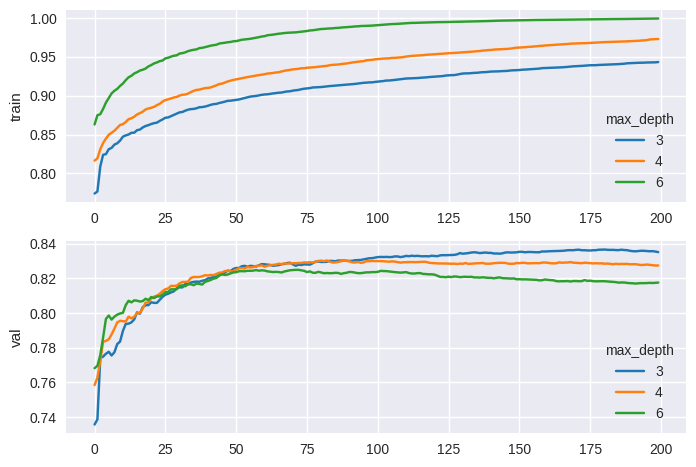

In [115]:
fig,ax=plt.subplots(nrows=2)
sns.lineplot(x=scores.index,y=scores.train,hue=scores.max_depth,palette='tab10',ax=ax[0])
sns.lineplot(x=scores.index,y=scores.val,hue=scores.max_depth,palette='tab10',ax=ax[1])

We see that the best `max_depth` is 3.

Now, we will tune `min_child_weight`

<AxesSubplot:ylabel='val'>

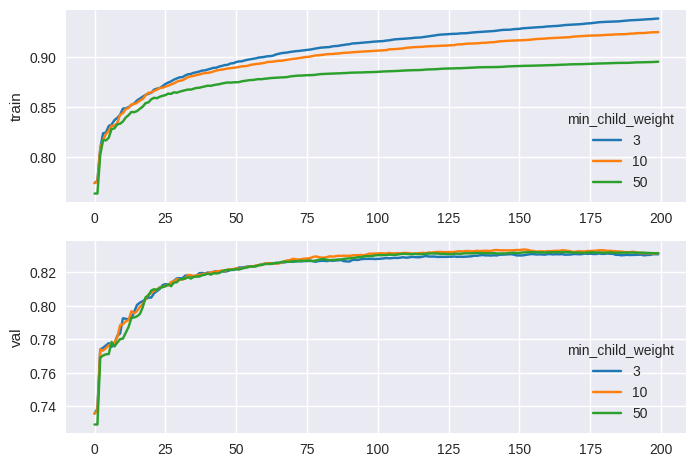

In [117]:
min_child = [3,10,50]
scores = pd.DataFrame()
for child in min_child:
    xgb_params = {
        "eta":0.1, #Learning rate
        "max_depth":3,
        "min_child_weight": child,

        "objective":"binary:logistic",
        "eval_metric" : 'auc',
        'nthread':8,

        'seed': 1,
        'verbosity':0,
    }

    evals_result = {}
    model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=200,
                    evals_result=evals_result,verbose_eval=False,evals=watch_list)
    df_scores = pd.DataFrame([evals_result['train']['auc'],evals_result['val']['auc']]).T
    df_scores.columns = ['train','val']
    df_scores['min_child_weight'] = child
    scores = pd.concat([scores,df_scores])


fig,ax=plt.subplots(nrows=2)
sns.lineplot(x=scores.index,y=scores.train,hue=scores.min_child_weight,palette='tab10',ax=ax[0])
sns.lineplot(x=scores.index,y=scores.val,hue=scores.min_child_weight,palette='tab10',ax=ax[1])

We see that the effect of changing this parameter does not affect the model performance significatively.

Let's train the model for 175 iterations

<AxesSubplot:>

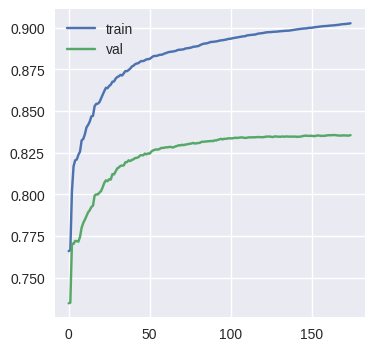

In [118]:

xgb_params = {
    "eta":0.1, #Learning rate
    "max_depth":3,
    "min_child_weight": 30,

    "objective":"binary:logistic",
    "eval_metric" : 'auc',
    'nthread':8,

    'seed': 1,
    'verbosity':0,
}

evals_result = {}

model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=175,
                evals_result=evals_result,verbose_eval=False,evals=watch_list)
df_scores = pd.DataFrame([evals_result['train']['auc'],evals_result['val']['auc']]).T
df_scores.columns = ['train','val']
df_scores.plot(figsize=(4,4)) 


## 6.9 Selecting the final model 

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [119]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7856948245380349

In [120]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [121]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8360387251459157

We see that the best model is the `xgboost`. So now, we will train this model but using the full training data (train + val)

In [122]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']

In [123]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [125]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [126]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8322662626460096

## 6.10 Summary
- Decision trees learn if-then-else rules from data.
- Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
- Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
- Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting.


## 6.11 Explore more
- For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in ExtraTreesClassifier. Try it for this project.
- XGBoost can deal with NAs - we don't have to do fillna for it. Check if not filling NA's help improve performance.
- Experiment with other XGBoost parameters: subsample and colsample_bytree.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for random forest (it's the same for plain decision trees) and for xgboost
- Trees can also be used for solving the regression problems: check DecisionTreeRegressor, RandomForestRegressor and the objective=reg:squarederror parameter for XGBoost.